In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("notebooks/pruning_quantization", "")))

import torch
from torch.utils.data import DataLoader
from config import Config
from data.dataset import NetworkDataset, load_datasets, get_subset
from model_config import MLP_Models, LSTM_Models, GRU_Models, CNN_models
from utils.benchmark import Benchmark
import warnings
from compact.pruning import prune_mlp_model, prune_rnn_model, prune_cnn_model
warnings.filterwarnings("ignore")

In [2]:
conf = Config()
load_model = MLP_Models()
#load_model = LSTM_Models()
#load_model = GRU_Models()
#load_model = CNN_models()
model_conf = load_model.mlp_4
model = load_model.get_model(model_conf)
model.load()
print(conf.device)

Checkpoint loaded from /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/large_model/mlp_4.pth!
cpu


In [3]:
# data loader
X_train, y_train, X_val, y_val, X_test, y_test = load_datasets(conf.datasets, model_type=load_model.type)

# create train, val and test dataloaders
dataset = NetworkDataset(X_test, y_test)
subset, length = get_subset(dataset, y_test)
loader = DataLoader(subset, conf.batch_size, shuffle=True)
assert conf.batch_size < length

In [4]:
# prune model
checkpoint_path = os.path.join(conf.checkpoint, "pruned_quantized", "pruned_" + model_conf["name"] + ".pth")
model.checkpoint_path = checkpoint_path

# new hidden sizes
if load_model.type == "mlp":
    pruned_model = prune_mlp_model(model.model, prune_ratio=0.4)
elif load_model.type == "rnn":
    pruned_model = prune_rnn_model(model.model, prune_ratio=0.4)
elif load_model.type == "cnn":
    pruned_model = prune_cnn_model(model.model, prune_ratio=0.4)
else:
    raise ValueError("model type must be 'mlp', 'rnn' or 'cnn'!")
    

model.model = pruned_model.to(conf.device)
model.optimizer = torch.optim.AdamW(
    model.model.parameters(), 
    lr=conf.learning_rate, 
    weight_decay=conf.weight_decay
)
model.scheduler = torch.optim.lr_scheduler.ExponentialLR(
    model.optimizer, 
    gamma=conf.gamma
)
model.load()

Checkpoint loaded from /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/pruned_quantized/pruned_mlp_4.pth!


Warmup Done!
Memory Benchmark Done!
Latency Benchmark Done!


ERROR:2026-01-29 16:58:24 3906297:3906297 DeviceProperties.cpp:47] gpuGetDeviceCount failed with code 35


Throughput Benchmark Done!
CPU Benchmark Done!
Metrics Benchmark Done!


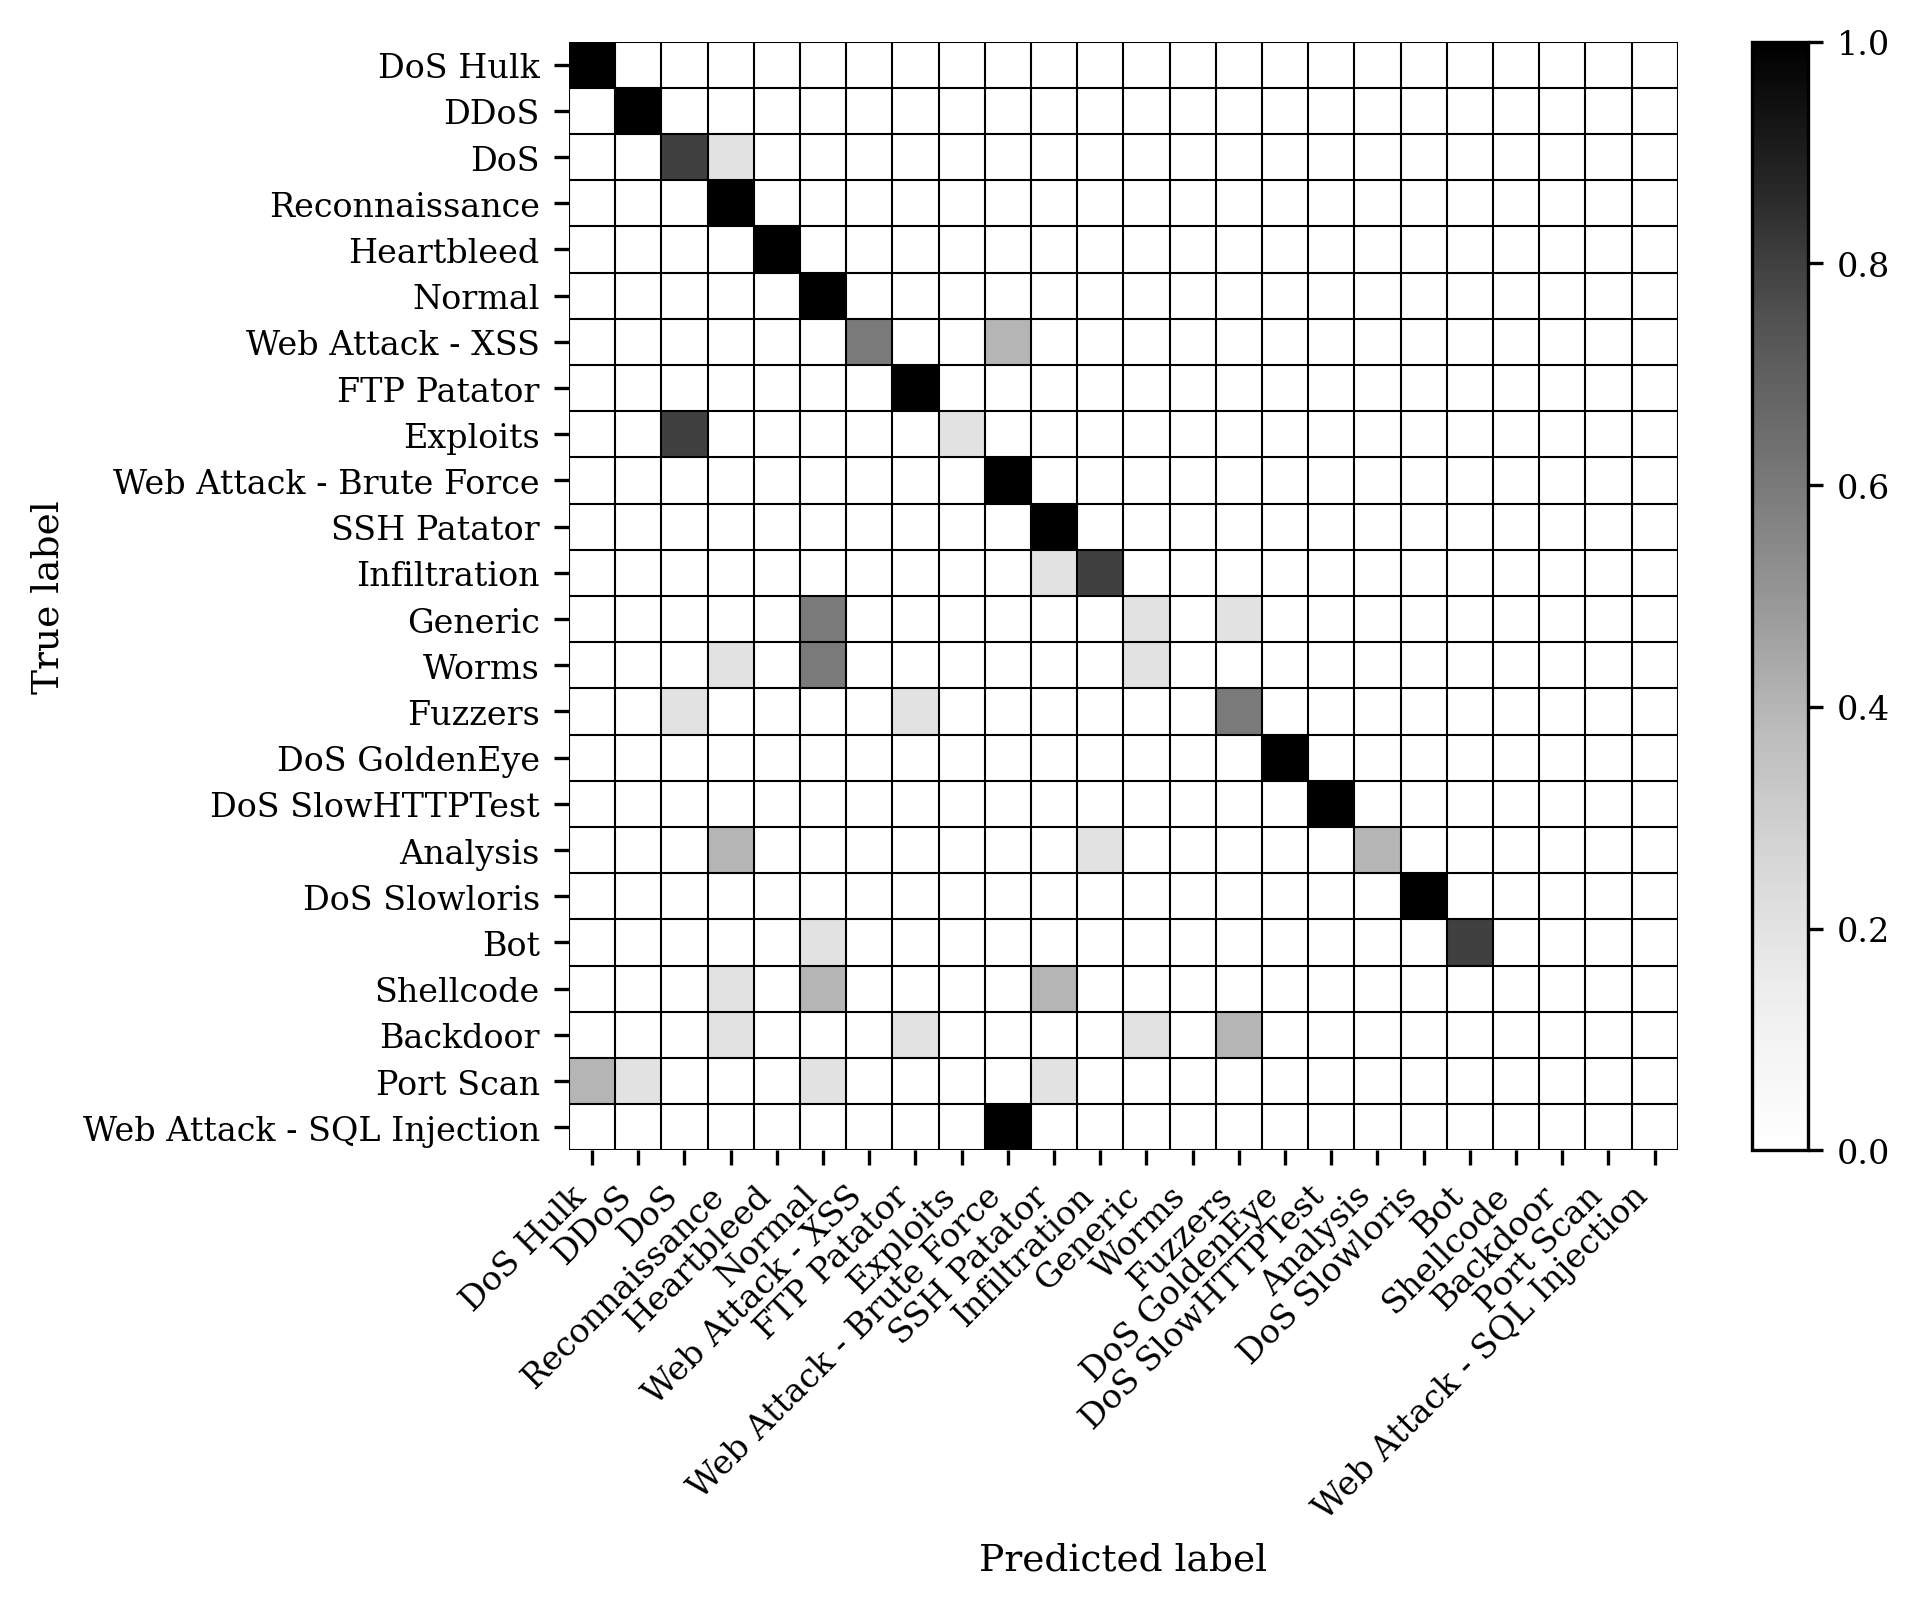

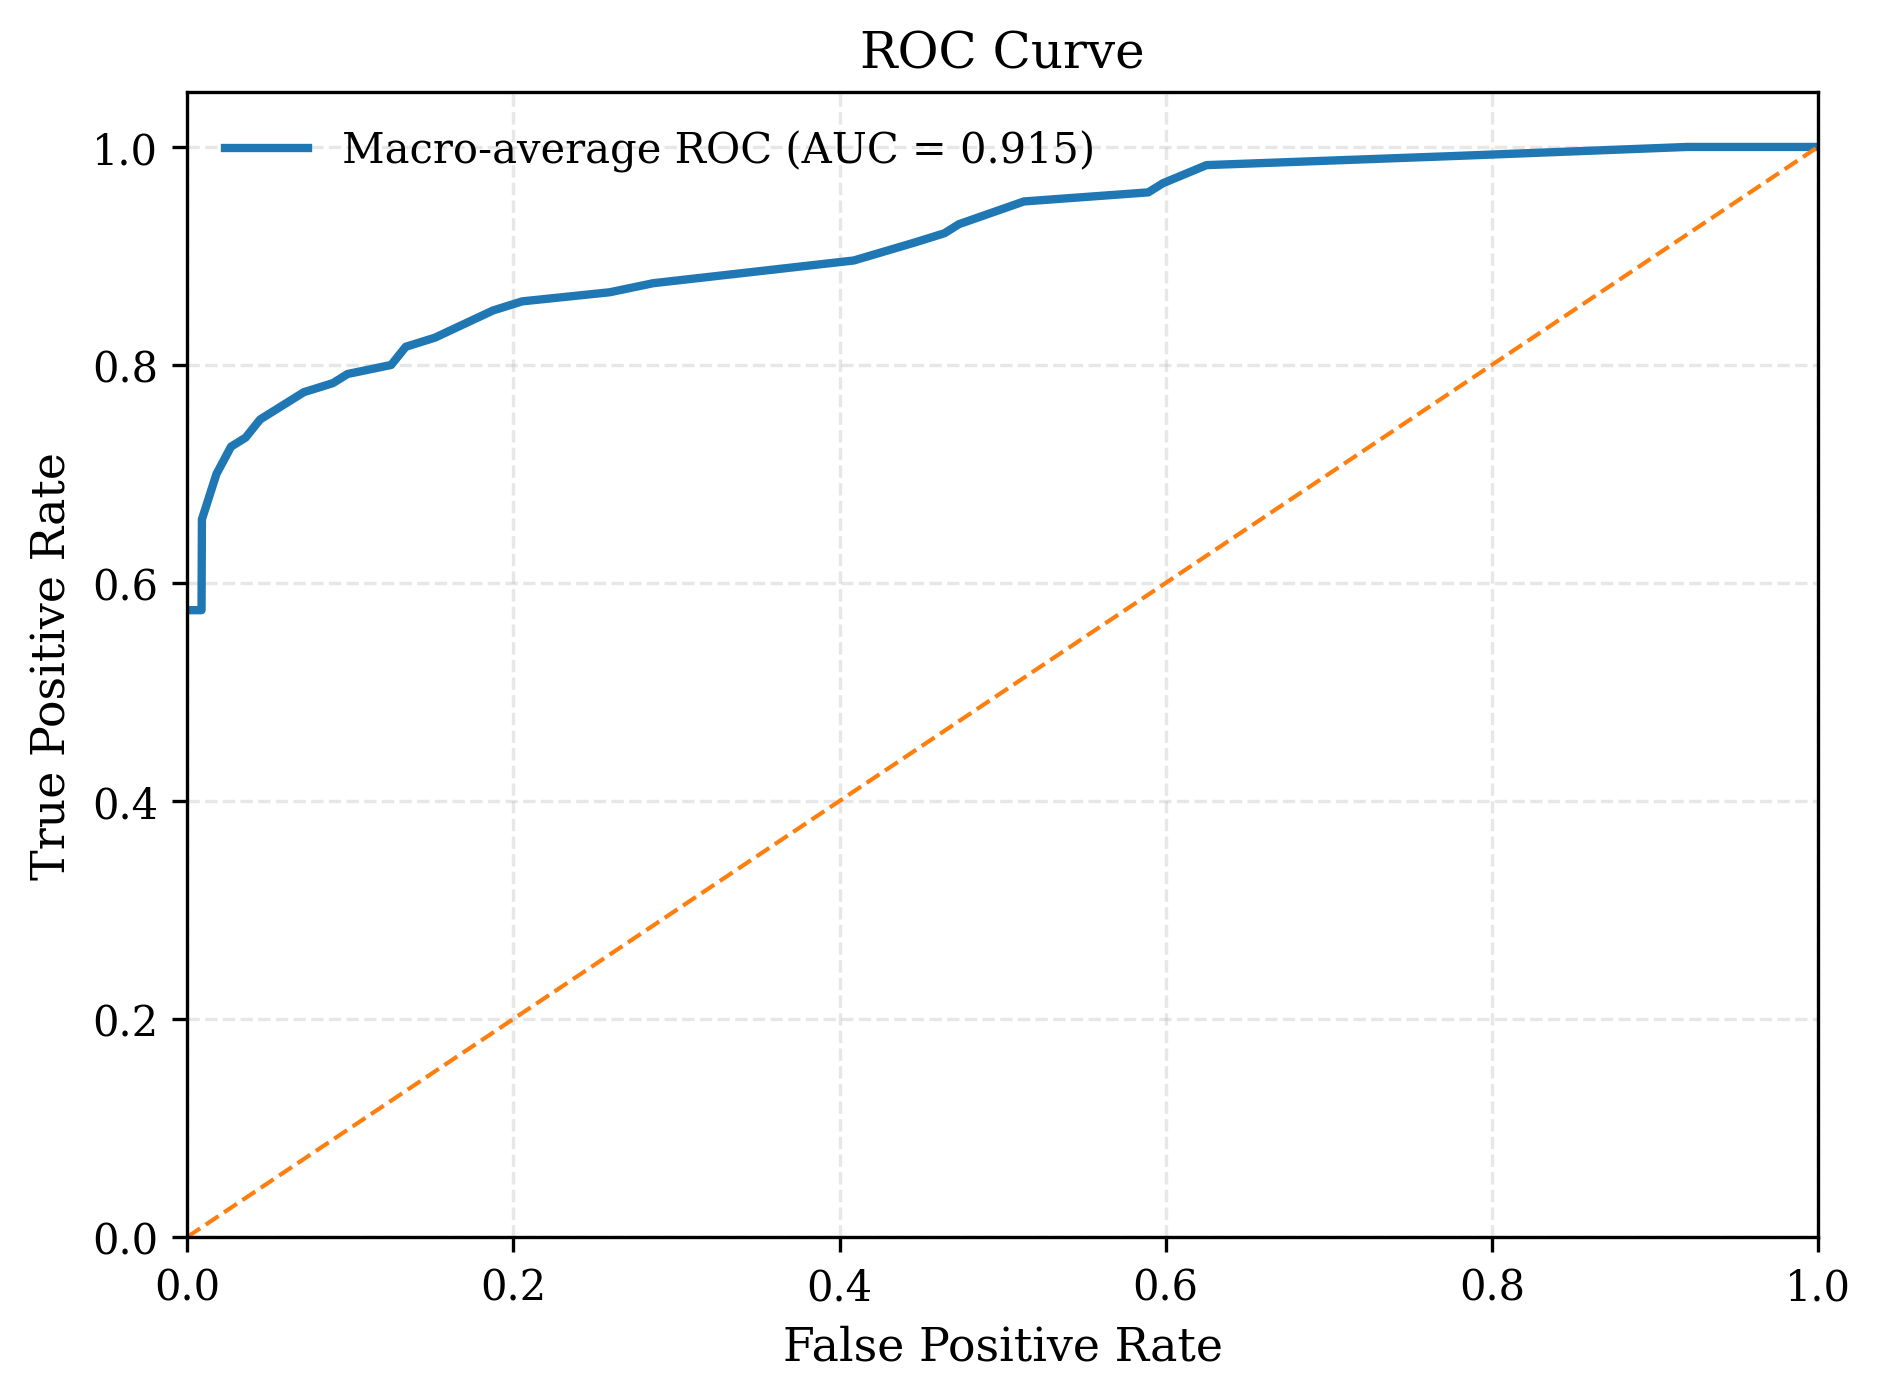

,Section,Metric,Value
0,Info,Name,pruned_mlp_4
1,Info,Batch Size,1
2,Info,Samples,117
3,Info,Location,Host
4,Memory,Avg. (MB),0.003
5,Memory,Peak (MB),0.039
6,Memory,Model (MB),0.841
7,Latency,Total (ms),22.979
8,Latency,Avg. (ms),0.196
9,Latency,Min (ms),0.192


In [5]:
# benchmark model
name = "pruned_" + model_conf["name"]
result_path = os.path.join(conf.benchmark_host, "pruned_quantized_model", name + ".csv")
plot_path = os.path.join(conf.plot, conf.location, "pruned_quantized_model")

benchmark = Benchmark(model, loader, conf.batch_size, name, result_path, runs=length)
benchmark(plot=True, plot_path=plot_path)

# print and save result
benchmark.print_result()
benchmark.save()
